# SRI-Performance Gap Correlation Demo

**Testing Whether Spectral Resolution Index Predicts RWSE vs LapPE Encoding Quality**

This notebook demonstrates the SRI-Performance Gap Correlation experiment, which tests whether the Spectral Resolution Index (SRI = K × δ_min) predicts the per-graph performance gap between RWSE and LapPE positional encodings.

**Phases:**
- **Phase 0**: Data loading & feature extraction
- **Phase 1**: SRI distribution analysis
- **Phase 2**: Model-free encoding quality (node distinguishability via pairwise distances)
- **Phase 3**: MLP proxy training (RWSE vs LapPE features → target prediction)
- **Phase 4**: Correlation analysis (Spearman ρ, bootstrap CIs, quintile stratification)
- **Phase 5**: Visualization

In [1]:
import subprocess, sys
def _pip(*a): subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', *a])

# loguru — NOT on Colab, always install
_pip('loguru==0.7.3')

# numpy, scipy, scikit-learn, matplotlib — pre-installed on Colab, install locally only
if 'google.colab' not in sys.modules:
    _pip('numpy==2.0.2', 'scipy==1.16.3', 'scikit-learn==1.6.1', 'matplotlib==3.10.0')


[notice] A new release of pip is available: 24.0 -> 26.0.1
[notice] To update, run: python3 -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 26.0.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [2]:
import os
import json
import math
import warnings
from typing import Any

import numpy as np
from scipy import stats
from scipy.spatial.distance import pdist
from scipy.linalg import eigh
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
import matplotlib
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

RNG_SEED = 42
np.random.seed(RNG_SEED)
print("Imports OK")

Imports OK


## Data Loading

Load the demo dataset (ZINC-subset, 80 graphs with diverse SRI values).

In [3]:
GITHUB_DATA_URL = "https://raw.githubusercontent.com/AMGrobelnik/ai-invention-ace67e-the-walk-resolution-limit-a-super-resolu/main/experiment_iter2_sri_performance/demo/mini_demo_data.json"

def load_data():
    try:
        import urllib.request
        with urllib.request.urlopen(GITHUB_DATA_URL) as response:
            return json.loads(response.read().decode())
    except Exception: pass
    if os.path.exists("mini_demo_data.json"):
        with open("mini_demo_data.json") as f: return json.load(f)
    raise FileNotFoundError("Could not load mini_demo_data.json")

In [4]:
data = load_data()
for ds in data["datasets"]:
    print(f"Dataset: {ds['dataset']}, Examples: {len(ds['examples'])}")

Dataset: ZINC-subset, Examples: 80


## Configuration

All tunable parameters for the experiment. Adjust these to control runtime vs result quality.

In [5]:
# ── Configuration ─────────────────────────────────────────────
# Phase 2: Model-free encoding quality
MAX_NODES_PHASE2 = 500          # Original: 500 — skip graphs larger than this
MAX_SAMPLE_PDIST = 100          # Original: 100 — subsample nodes for pairwise distances

# Phase 3: MLP proxy training
MLP_HIDDEN_SIZES = (128, 64)    # Original: (128, 64)
MLP_MAX_ITER = 500              # Original: 500
MLP_N_ITER_NO_CHANGE = 15       # Original: 15
MLP_VALIDATION_FRACTION = 0.15  # Original: 0.15
MLP_SEEDS = [42, 123, 456]     # Original: [42, 123, 456]
NUM_EIGVECS = 16                # Original: 16 — number of Laplacian eigenvectors
N_BINS_HIST = 31                # Original: 31 — eigenvalue histogram bins

# Phase 4: Correlation analysis
N_BOOTSTRAP = 1000              # Original: 1000

# Train/val/test split fractions
TRAIN_FRAC = 0.7                # Original: 0.7
VAL_FRAC = 0.15                 # Original: 0.15

print("Config set — full original values (80-graph demo runs fast)")

Config set — full original values (80-graph demo runs fast)


## Phase 0: Data Parsing & Feature Extraction

Parse raw graph examples into structured records with spectral features (eigenvalues, SRI, RWSE, Vandermonde condition number).

In [6]:
def parse_example(ex, ds_name):
    """Parse a single example into a lightweight record."""
    inp = json.loads(ex["input"])
    spec = inp["spectral"]

    num_nodes = inp["num_nodes"]
    edge_index = inp["edge_index"]  # [[src...], [dst...]]

    # Spectral features
    eigenvalues = np.array(spec["eigenvalues"], dtype=np.float64)
    delta_min = float(spec["delta_min"])
    sri_dict = spec["sri"]
    sri_k20 = float(sri_dict.get("K=20", sri_dict.get("K=16", 0.0)))
    vander_cond = spec["vandermonde_cond"]
    vander_k20 = float(vander_cond.get("K=20", vander_cond.get("K=16", 1e15)))

    # RWSE: list of lists (num_nodes × 20)
    rwse = np.array(spec["rwse"], dtype=np.float64)

    # Target
    output_raw = ex["output"]

    # Fold
    fold = ex.get("metadata_fold", 0)
    task_type = ex.get("metadata_task_type", "regression")

    return {
        "dataset": ds_name,
        "num_nodes": num_nodes,
        "edge_index": edge_index,
        "eigenvalues": eigenvalues,
        "delta_min": delta_min,
        "sri_k20": sri_k20,
        "vander_k20": vander_k20,
        "rwse": rwse,
        "fold": fold,
        "task_type": task_type,
        "output_raw": output_raw,
        "row_index": ex.get("metadata_row_index", 0),
    }


def parse_target(output_raw, task_type):
    """Parse the output string into a float array."""
    if task_type == "classification":
        return np.array(json.loads(output_raw), dtype=np.float64)
    elif task_type == "regression":
        val = output_raw.strip()
        if val.startswith("["):
            return np.array(json.loads(val), dtype=np.float64)
        else:
            return np.array([float(val)], dtype=np.float64)
    else:
        return np.array([float(output_raw)], dtype=np.float64)


# Parse all examples from loaded data
records = {}
for ds in data["datasets"]:
    ds_name = ds["dataset"]
    records[ds_name] = []
    for ex in ds["examples"]:
        try:
            rec = parse_example(ex, ds_name)
            records[ds_name].append(rec)
        except Exception as e:
            print(f"  Failed parsing: {e}")
            continue

for ds_name, recs in records.items():
    print(f"  {ds_name}: {len(recs)} records parsed")

  ZINC-subset: 80 records parsed


## Feature Construction Helpers

Build adjacency/Laplacian matrices, compute RWSE graph features, LapPE graph features, and eigenvalue histograms.

In [7]:
def build_adjacency(edge_index, num_nodes):
    """Build adjacency matrix from edge_index (vectorized)."""
    A = np.zeros((num_nodes, num_nodes), dtype=np.float64)
    src = np.array(edge_index[0], dtype=np.int64)
    dst = np.array(edge_index[1], dtype=np.int64)
    mask = (src < num_nodes) & (dst < num_nodes)
    src, dst = src[mask], dst[mask]
    A[src, dst] = 1.0
    A[dst, src] = 1.0
    return A


def build_laplacian(A):
    """Build graph Laplacian L = D - A."""
    D = np.diag(A.sum(axis=1))
    return D - A


def rwse_graph_features(rwse):
    """Aggregate per-node RWSE (n×20) to graph-level features.
    Returns 80-dim vector: mean/std/max/min across nodes for each walk length."""
    if rwse.shape[0] == 0:
        return np.zeros(80, dtype=np.float64)
    mean_f = rwse.mean(axis=0)  # 20
    std_f = rwse.std(axis=0)    # 20
    max_f = rwse.max(axis=0)    # 20
    min_f = rwse.min(axis=0)    # 20
    return np.concatenate([mean_f, std_f, max_f, min_f])


def lape_graph_features(A, num_eigvecs=NUM_EIGVECS):
    """Compute LapPE features: |eigenvectors| of L, aggregated.
    Returns (4 × num_eigvecs)-dim vector."""
    n = A.shape[0]
    L = build_laplacian(A)
    try:
        eigenvalues, eigvecs = eigh(L)
    except Exception:
        return np.zeros(num_eigvecs * 4, dtype=np.float64)

    k = min(num_eigvecs, n - 1)
    if k <= 0:
        return np.zeros(num_eigvecs * 4, dtype=np.float64)

    V = np.abs(eigvecs[:, 1:k+1])  # n × k
    if k < num_eigvecs:
        V = np.pad(V, ((0, 0), (0, num_eigvecs - k)), mode="constant")

    mean_f = V.mean(axis=0)
    std_f = V.std(axis=0)
    max_f = V.max(axis=0)
    min_f = V.min(axis=0)
    return np.concatenate([mean_f, std_f, max_f, min_f])


def eigenvalue_histogram(eigenvalues, n_bins=N_BINS_HIST):
    """Histogram of eigenvalues, normalized."""
    if len(eigenvalues) == 0:
        return np.zeros(n_bins, dtype=np.float64)
    hist, _ = np.histogram(eigenvalues, bins=n_bins, range=(-3, 3), density=False)
    total = hist.sum()
    if total > 0:
        hist = hist / total
    return hist.astype(np.float64)


print("Feature helpers defined")

Feature helpers defined


## Phase 1: SRI Distribution Analysis

Compute SRI distribution statistics (mean, median, percentiles) and visualize the histogram.

=== PHASE 1: SRI Distribution Analysis ===
  ZINC-subset: mean SRI=1.1616, median=0.9917, frac<1=0.5000


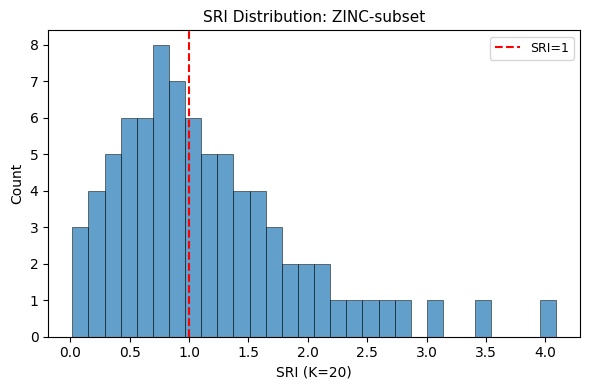

In [8]:
print("=== PHASE 1: SRI Distribution Analysis ===")
phase1_results = {}

for ds_name, recs in records.items():
    sri_vals = np.array([r["sri_k20"] for r in recs])
    stats_dict = {
        "count": len(sri_vals),
        "mean": float(np.mean(sri_vals)),
        "median": float(np.median(sri_vals)),
        "std": float(np.std(sri_vals)),
        "p5": float(np.percentile(sri_vals, 5)),
        "p25": float(np.percentile(sri_vals, 25)),
        "p75": float(np.percentile(sri_vals, 75)),
        "p95": float(np.percentile(sri_vals, 95)),
        "frac_below_1": float(np.mean(sri_vals < 1.0)),
    }
    phase1_results[ds_name] = stats_dict
    print(f"  {ds_name}: mean SRI={stats_dict['mean']:.4f}, median={stats_dict['median']:.4f}, "
          f"frac<1={stats_dict['frac_below_1']:.4f}")

    # Plot histogram
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.hist(sri_vals, bins=30, alpha=0.7, edgecolor="black", linewidth=0.5)
    ax.axvline(x=1.0, color="red", linestyle="--", linewidth=1.5, label="SRI=1")
    ax.set_title(f"SRI Distribution: {ds_name}", fontsize=11)
    ax.set_xlabel("SRI (K=20)")
    ax.set_ylabel("Count")
    ax.legend(fontsize=9)
    plt.tight_layout()
    plt.show()

## Phase 2: Model-Free Encoding Quality

For each graph, compute the median pairwise L2 distance between nodes using spectral features vs RWSE features. The quality gap = d_spec - d_rwse (positive means spectral is better at distinguishing nodes).

In [9]:
def _subsample_pdist_median(X, max_sample=MAX_SAMPLE_PDIST, rng_seed=42):
    """Compute median pairwise L2 distance, subsampling nodes if n > max_sample."""
    n = X.shape[0]
    if n <= max_sample:
        return float(np.median(pdist(X, metric="euclidean")))
    rng = np.random.RandomState(rng_seed)
    idx = rng.choice(n, size=max_sample, replace=False)
    return float(np.median(pdist(X[idx], metric="euclidean")))


print("=== PHASE 2: Model-Free Encoding Quality ===")
phase2_results = {}

for ds_name, recs in records.items():
    print(f"  Processing {ds_name} ({len(recs)} graphs) ...")
    sri_vals = []
    quality_gaps = []
    delta_mins = []
    log_vander = []

    for rec in recs:
        n = rec["num_nodes"]
        if n > MAX_NODES_PHASE2 or n < 3:
            continue

        rwse = rec["rwse"]
        if rwse.shape[0] != n or rwse.shape[1] < 1:
            continue

        try:
            A = build_adjacency(rec["edge_index"], n)
            eigvals_A, eigvecs_A = eigh(A)
            k_spec = min(20, n)
            spec_feats = eigvecs_A[:, -k_spec:] ** 2
        except Exception:
            continue

        rwse_f = rwse[:, :min(20, rwse.shape[1])]
        spec_f = spec_feats[:, :min(20, spec_feats.shape[1])]

        max_cols = max(rwse_f.shape[1], spec_f.shape[1])
        if rwse_f.shape[1] < max_cols:
            rwse_f = np.pad(rwse_f, ((0, 0), (0, max_cols - rwse_f.shape[1])))
        if spec_f.shape[1] < max_cols:
            spec_f = np.pad(spec_f, ((0, 0), (0, max_cols - spec_f.shape[1])))

        if n >= 2:
            d_rwse = _subsample_pdist_median(rwse_f)
            d_spec = _subsample_pdist_median(spec_f)
            gap = d_spec - d_rwse
        else:
            continue

        sri_vals.append(rec["sri_k20"])
        quality_gaps.append(gap)
        delta_mins.append(rec["delta_min"])
        log_vander.append(math.log10(rec["vander_k20"] + 1))

    if len(sri_vals) < 5:
        print(f"  {ds_name}: only {len(sri_vals)} valid graphs, skipping correlation")
        phase2_results[ds_name] = {"n_valid": len(sri_vals)}
        continue

    sri_arr = np.array(sri_vals)
    gap_arr = np.array(quality_gaps)
    dm_arr = np.array(delta_mins)
    lv_arr = np.array(log_vander)

    rho_sri, p_sri = stats.spearmanr(sri_arr, gap_arr)
    rho_dm, p_dm = stats.spearmanr(dm_arr, gap_arr)
    rho_lv, p_lv = stats.spearmanr(lv_arr, gap_arr)

    phase2_results[ds_name] = {
        "n_valid": len(sri_vals),
        "spearman_sri_vs_gap": {"rho": float(rho_sri), "p": float(p_sri)},
        "spearman_deltamin_vs_gap": {"rho": float(rho_dm), "p": float(p_dm)},
        "spearman_logvander_vs_gap": {"rho": float(rho_lv), "p": float(p_lv)},
        "mean_quality_gap": float(np.mean(gap_arr)),
    }
    print(f"  {ds_name}: n={len(sri_vals)}, rho(SRI,gap)={rho_sri:.4f} (p={p_sri:.4e})")

=== PHASE 2: Model-Free Encoding Quality ===
  Processing ZINC-subset (80 graphs) ...
  ZINC-subset: n=80, rho(SRI,gap)=0.3431 (p=1.8336e-03)


## Phase 3: MLP Proxy Training

Train MLP regressors using RWSE features and LapPE features separately, then compute the per-graph MAE gap (RWSE_loss - LapPE_loss). A positive gap means LapPE is better for that graph.

In [10]:
def split_indices(n, train_frac=TRAIN_FRAC, val_frac=VAL_FRAC, seed=RNG_SEED):
    """Split indices into train/val/test."""
    rng = np.random.RandomState(seed)
    perm = rng.permutation(n)
    n_train = int(n * train_frac)
    n_val = int(n * val_frac)
    return perm[:n_train], perm[n_train:n_train + n_val], perm[n_train + n_val:]


print("=== PHASE 3: MLP Proxy Training ===")
phase3_results = {}

# Process each dataset that has records
for ds_name in records.keys():
    recs = records[ds_name]
    n = len(recs)
    print(f"  {ds_name}: building features for {n} graphs ...")

    rwse_feats_list = []
    lape_feats_list = []
    eig_hist_list = []
    targets_list = []
    sri_vals = []
    delta_mins = []
    log_vander_vals = []
    num_nodes_list = []

    for i, rec in enumerate(recs):
        try:
            rwse_gf = rwse_graph_features(rec["rwse"])
            n_nodes = rec["num_nodes"]
            if n_nodes <= 2:
                continue
            A = build_adjacency(rec["edge_index"], n_nodes)
            lape_gf = lape_graph_features(A, num_eigvecs=NUM_EIGVECS)
            eig_hist = eigenvalue_histogram(rec["eigenvalues"])
            target = parse_target(rec["output_raw"], rec["task_type"])

            rwse_feats_list.append(rwse_gf)
            lape_feats_list.append(lape_gf)
            eig_hist_list.append(eig_hist)
            targets_list.append(target)
            sri_vals.append(rec["sri_k20"])
            delta_mins.append(rec["delta_min"])
            log_vander_vals.append(math.log10(rec["vander_k20"] + 1))
            num_nodes_list.append(n_nodes)
        except Exception:
            continue

    n_valid = len(rwse_feats_list)
    print(f"    {n_valid}/{n} valid feature vectors")
    if n_valid < 20:
        print(f"  {ds_name}: too few valid examples ({n_valid}), skipping MLP")
        continue

    X_rwse = np.array(rwse_feats_list)
    X_lape = np.array(lape_feats_list)
    X_eig = np.array(eig_hist_list)
    y_all = np.array(targets_list)
    sri_arr = np.array(sri_vals)
    dm_arr = np.array(delta_mins)
    lv_arr = np.array(log_vander_vals)
    nn_arr = np.array(num_nodes_list)

    X_rwse_full = np.hstack([X_rwse, X_eig])  # 80 + 31 = 111
    X_lape_full = np.hstack([X_lape, X_eig])  # 64 + 31 = 95

    train_idx, val_idx, test_idx = split_indices(n_valid, seed=RNG_SEED)
    print(f"    Split: train={len(train_idx)}, val={len(val_idx)}, test={len(test_idx)}")

    per_graph_loss_rwse = np.zeros((len(test_idx), len(MLP_SEEDS)))
    per_graph_loss_lape = np.zeros((len(test_idx), len(MLP_SEEDS)))

    for seed_idx, seed in enumerate(MLP_SEEDS):
        print(f"    Training MLP (seed={seed}) ...")

        scaler_r = StandardScaler()
        X_r_train = scaler_r.fit_transform(X_rwse_full[train_idx])
        X_r_test = scaler_r.transform(X_rwse_full[test_idx])

        scaler_l = StandardScaler()
        X_l_train = scaler_l.fit_transform(X_lape_full[train_idx])
        X_l_test = scaler_l.transform(X_lape_full[test_idx])

        y_train = y_all[train_idx]
        y_test = y_all[test_idx]

        for X in [X_r_train, X_r_test, X_l_train, X_l_test]:
            X[~np.isfinite(X)] = 0.0

        try:
            mlp_rwse = MLPRegressor(
                hidden_layer_sizes=MLP_HIDDEN_SIZES,
                max_iter=MLP_MAX_ITER,
                early_stopping=True,
                validation_fraction=MLP_VALIDATION_FRACTION,
                random_state=seed,
                learning_rate="adaptive",
                n_iter_no_change=MLP_N_ITER_NO_CHANGE,
            )
            mlp_rwse.fit(X_r_train, y_train)
            pred_rwse = mlp_rwse.predict(X_r_test)
            per_graph_mae_rwse = np.abs(pred_rwse - y_test).mean(axis=-1) if y_test.ndim > 1 else np.abs(pred_rwse - y_test)
            per_graph_loss_rwse[:, seed_idx] = per_graph_mae_rwse
            print(f"      RWSE MLP: test MAE = {per_graph_mae_rwse.mean():.4f}")
        except Exception as e:
            print(f"      RWSE MLP failed: {e}")
            per_graph_loss_rwse[:, seed_idx] = np.nan

        try:
            mlp_lape = MLPRegressor(
                hidden_layer_sizes=MLP_HIDDEN_SIZES,
                max_iter=MLP_MAX_ITER,
                early_stopping=True,
                validation_fraction=MLP_VALIDATION_FRACTION,
                random_state=seed,
                learning_rate="adaptive",
                n_iter_no_change=MLP_N_ITER_NO_CHANGE,
            )
            mlp_lape.fit(X_l_train, y_train)
            pred_lape = mlp_lape.predict(X_l_test)
            per_graph_mae_lape = np.abs(pred_lape - y_test).mean(axis=-1) if y_test.ndim > 1 else np.abs(pred_lape - y_test)
            per_graph_loss_lape[:, seed_idx] = per_graph_mae_lape
            print(f"      LapPE MLP: test MAE = {per_graph_mae_lape.mean():.4f}")
        except Exception as e:
            print(f"      LapPE MLP failed: {e}")
            per_graph_loss_lape[:, seed_idx] = np.nan

    mean_loss_rwse = np.nanmean(per_graph_loss_rwse, axis=1)
    mean_loss_lape = np.nanmean(per_graph_loss_lape, axis=1)
    gap = mean_loss_rwse - mean_loss_lape

    sri_test = sri_arr[test_idx]
    dm_test = dm_arr[test_idx]
    lv_test = lv_arr[test_idx]
    nn_test = nn_arr[test_idx]

    phase3_results[ds_name] = {
        "n_train": int(len(train_idx)),
        "n_test": int(len(test_idx)),
        "mean_mae_rwse": float(np.nanmean(mean_loss_rwse)),
        "mean_mae_lape": float(np.nanmean(mean_loss_lape)),
        "mean_gap": float(np.nanmean(gap)),
        "_gap": gap,
        "_sri_test": sri_test,
        "_dm_test": dm_test,
        "_lv_test": lv_test,
        "_nn_test": nn_test,
    }
    print(f"    Mean MAE: RWSE={np.nanmean(mean_loss_rwse):.4f}, "
          f"LapPE={np.nanmean(mean_loss_lape):.4f}, gap={np.nanmean(gap):.4f}")

=== PHASE 3: MLP Proxy Training ===
  ZINC-subset: building features for 80 graphs ...
    80/80 valid feature vectors
    Split: train=56, val=12, test=12
    Training MLP (seed=42) ...
      RWSE MLP: test MAE = 1.0839
      LapPE MLP: test MAE = 1.0983
    Training MLP (seed=123) ...


      RWSE MLP: test MAE = 1.5896


      LapPE MLP: test MAE = 1.2538


    Training MLP (seed=456) ...


      RWSE MLP: test MAE = 1.1316


      LapPE MLP: test MAE = 1.4234
    Mean MAE: RWSE=1.2684, LapPE=1.2585, gap=0.0099


## Phase 4: Correlation Analysis

Compute Spearman correlations between SRI and the MAE gap, with bootstrap confidence intervals and quintile stratification.

In [11]:
def bootstrap_spearman(x, y, n_boot=N_BOOTSTRAP, seed=42):
    """Bootstrap 95% CI for Spearman rho."""
    rng = np.random.RandomState(seed)
    n = len(x)
    rhos = []
    for _ in range(n_boot):
        idx = rng.randint(0, n, size=n)
        r, _ = stats.spearmanr(x[idx], y[idx])
        if np.isfinite(r):
            rhos.append(r)
    if not rhos:
        return {"rho_mean": 0.0, "ci_low": 0.0, "ci_high": 0.0}
    rhos = np.array(rhos)
    return {
        "rho_mean": float(np.mean(rhos)),
        "ci_low": float(np.percentile(rhos, 2.5)),
        "ci_high": float(np.percentile(rhos, 97.5)),
    }


print("=== PHASE 4: Correlation Analysis ===")
phase4_results = {}

for ds_name, res in phase3_results.items():
    if "_gap" not in res:
        continue

    gap = res["_gap"]
    sri = res["_sri_test"]
    dm = res["_dm_test"]
    lv = res["_lv_test"]
    nn = res["_nn_test"]

    mask = np.isfinite(gap) & np.isfinite(sri) & np.isfinite(dm) & np.isfinite(lv)
    gap = gap[mask]
    sri = sri[mask]
    dm = dm[mask]
    lv = lv[mask]
    nn = nn[mask]

    if len(gap) < 10:
        print(f"  {ds_name}: too few valid test points ({len(gap)})")
        continue

    rho_sri, p_sri = stats.spearmanr(sri, gap)
    rho_dm, p_dm = stats.spearmanr(dm, gap)
    rho_lv, p_lv = stats.spearmanr(lv, gap)

    boot_sri = bootstrap_spearman(sri, gap)
    boot_dm = bootstrap_spearman(dm, gap)

    # SRI quintile stratification
    quintile_edges = np.percentile(sri, [0, 20, 40, 60, 80, 100])
    quintile_means = []
    quintile_labels = []
    for q in range(5):
        low, high = quintile_edges[q], quintile_edges[q + 1]
        if q == 4:
            mask_q = (sri >= low) & (sri <= high)
        else:
            mask_q = (sri >= low) & (sri < high)
        if mask_q.sum() > 0:
            quintile_means.append(float(gap[mask_q].mean()))
            quintile_labels.append(f"Q{q+1} [{low:.2f}, {high:.2f}]")
        else:
            quintile_means.append(0.0)
            quintile_labels.append(f"Q{q+1}")

    tau, p_tau = stats.kendalltau(range(5), quintile_means)

    # Size-controlled analysis
    size_bins = np.percentile(nn, [0, 33, 67, 100])
    size_controlled = []
    for b in range(3):
        low, high = size_bins[b], size_bins[b + 1]
        if b == 2:
            mask_b = (nn >= low) & (nn <= high)
        else:
            mask_b = (nn >= low) & (nn < high)
        if mask_b.sum() >= 5:
            r, p = stats.spearmanr(sri[mask_b], gap[mask_b])
            size_controlled.append({
                "size_range": f"[{low:.0f}, {high:.0f}]",
                "n": int(mask_b.sum()),
                "rho": float(r),
                "p": float(p),
            })

    rho_sri_nn, p_sri_nn = stats.spearmanr(sri, nn)

    phase4_results[ds_name] = {
        "n_test": int(len(gap)),
        "primary": {
            "sri_vs_gap": {"rho": float(rho_sri), "p": float(p_sri), "bootstrap": boot_sri},
            "deltamin_vs_gap": {"rho": float(rho_dm), "p": float(p_dm), "bootstrap": boot_dm},
            "logvander_vs_gap": {"rho": float(rho_lv), "p": float(p_lv)},
        },
        "quintiles": {
            "labels": quintile_labels,
            "mean_gap": quintile_means,
            "kendall_tau": float(tau),
            "kendall_p": float(p_tau),
        },
        "size_controlled": size_controlled,
        "confounder": {
            "sri_vs_num_nodes": {"rho": float(rho_sri_nn), "p": float(p_sri_nn)},
        },
    }
    print(f"  {ds_name}: rho(SRI,gap)={rho_sri:.4f} [{boot_sri['ci_low']:.4f}, {boot_sri['ci_high']:.4f}], p={p_sri:.4e}")
    print(f"    Quintile trend (Kendall tau): {tau:.4f} (p={p_tau:.4e})")
    print(f"    SRI vs num_nodes: rho={rho_sri_nn:.4f}")

=== PHASE 4: Correlation Analysis ===


  ZINC-subset: rho(SRI,gap)=-0.0280 [-0.6467, 0.5959], p=9.3123e-01
    Quintile trend (Kendall tau): -0.2000 (p=8.1667e-01)
    SRI vs num_nodes: rho=-0.2100


## Phase 5: Visualization & Results Summary

Generate scatter plots (SRI vs gap, Vandermonde vs gap), quintile bar charts, and a results summary table.

=== PHASE 5: Visualization ===



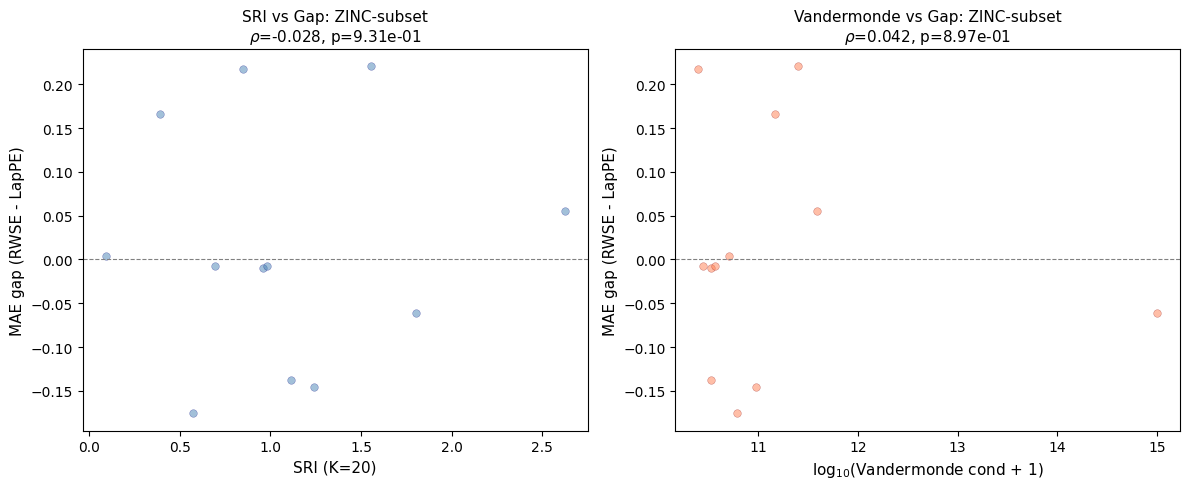

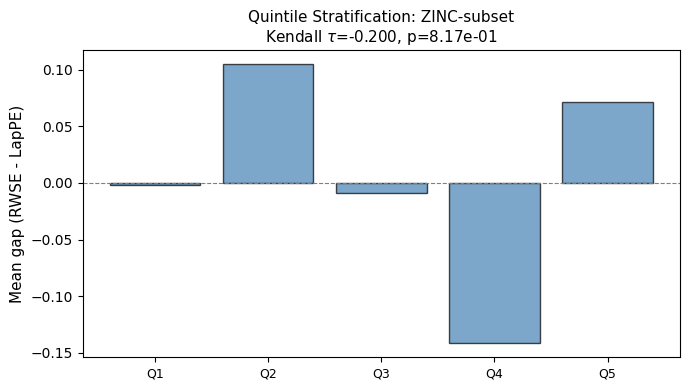


RESULTS SUMMARY

--- Phase 1: SRI Distributions ---
  ZINC-subset: n=80, mean=1.1616, median=0.9917, frac<1=0.50

--- Phase 2: Model-Free Encoding Quality ---
  ZINC-subset: n=80, rho(SRI,gap)=0.3431

--- Phase 3: MLP Proxy ---
  ZINC-subset: RWSE MAE=1.2684, LapPE MAE=1.2585, gap=0.0099

--- Phase 4: Correlation Analysis ---
  ZINC-subset: rho=-0.0280 [-0.6467, 0.5959], p=9.31e-01
    Quintile Kendall tau=-0.200

Demo complete!


In [12]:
print("=== PHASE 5: Visualization ===\n")

# 5a: SRI vs gap scatter
ds_with_gap = [ds for ds in phase3_results if "_gap" in phase3_results[ds]]
for ds_name in ds_with_gap:
    res = phase3_results[ds_name]
    gap = res["_gap"]
    sri = res["_sri_test"]
    mask = np.isfinite(gap) & np.isfinite(sri)

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # SRI vs gap scatter
    ax = axes[0]
    ax.scatter(sri[mask], gap[mask], alpha=0.5, s=30, c="steelblue", edgecolors="navy", linewidth=0.3)
    ax.set_xlabel("SRI (K=20)", fontsize=11)
    ax.set_ylabel("MAE gap (RWSE - LapPE)", fontsize=11)
    if ds_name in phase4_results:
        rho = phase4_results[ds_name]["primary"]["sri_vs_gap"]["rho"]
        p = phase4_results[ds_name]["primary"]["sri_vs_gap"]["p"]
        ax.set_title(f"SRI vs Gap: {ds_name}\n$\\rho$={rho:.3f}, p={p:.2e}", fontsize=11)
    ax.axhline(y=0, color="grey", linestyle="--", linewidth=0.8)

    # Vandermonde cond vs gap scatter
    lv = res["_lv_test"]
    ax = axes[1]
    ax.scatter(lv[mask], gap[mask], alpha=0.5, s=30, c="coral", edgecolors="darkred", linewidth=0.3)
    ax.set_xlabel("log$_{10}$(Vandermonde cond + 1)", fontsize=11)
    ax.set_ylabel("MAE gap (RWSE - LapPE)", fontsize=11)
    if ds_name in phase4_results:
        rho_lv = phase4_results[ds_name]["primary"]["logvander_vs_gap"]["rho"]
        p_lv = phase4_results[ds_name]["primary"]["logvander_vs_gap"]["p"]
        ax.set_title(f"Vandermonde vs Gap: {ds_name}\n$\\rho$={rho_lv:.3f}, p={p_lv:.2e}", fontsize=11)
    ax.axhline(y=0, color="grey", linestyle="--", linewidth=0.8)

    plt.tight_layout()
    plt.show()

# 5b: Quintile bar chart
for ds_name in phase4_results:
    if "quintiles" not in phase4_results[ds_name]:
        continue
    q_data = phase4_results[ds_name]["quintiles"]

    fig, ax = plt.subplots(figsize=(7, 4))
    bars = ax.bar(range(5), q_data["mean_gap"], color="steelblue", alpha=0.7, edgecolor="black")
    ax.set_xticks(range(5))
    ax.set_xticklabels([f"Q{i+1}" for i in range(5)], fontsize=9)
    ax.set_ylabel("Mean gap (RWSE - LapPE)", fontsize=11)
    tau = q_data["kendall_tau"]
    p_tau = q_data["kendall_p"]
    ax.set_title(f"Quintile Stratification: {ds_name}\nKendall $\\tau$={tau:.3f}, p={p_tau:.2e}", fontsize=11)
    ax.axhline(y=0, color="grey", linestyle="--", linewidth=0.8)
    plt.tight_layout()
    plt.show()

# 5c: Results summary table
print("\n" + "=" * 70)
print("RESULTS SUMMARY")
print("=" * 70)

# Phase 1 summary
print("\n--- Phase 1: SRI Distributions ---")
for ds_name, s in phase1_results.items():
    print(f"  {ds_name}: n={s['count']}, mean={s['mean']:.4f}, median={s['median']:.4f}, frac<1={s['frac_below_1']:.2f}")

# Phase 2 summary
print("\n--- Phase 2: Model-Free Encoding Quality ---")
for ds_name, s in phase2_results.items():
    if "spearman_sri_vs_gap" in s:
        print(f"  {ds_name}: n={s['n_valid']}, rho(SRI,gap)={s['spearman_sri_vs_gap']['rho']:.4f}")

# Phase 3 summary
print("\n--- Phase 3: MLP Proxy ---")
for ds_name, s in phase3_results.items():
    print(f"  {ds_name}: RWSE MAE={s['mean_mae_rwse']:.4f}, LapPE MAE={s['mean_mae_lape']:.4f}, gap={s['mean_gap']:.4f}")

# Phase 4 summary
print("\n--- Phase 4: Correlation Analysis ---")
for ds_name, s in phase4_results.items():
    p = s["primary"]["sri_vs_gap"]
    b = p["bootstrap"]
    print(f"  {ds_name}: rho={p['rho']:.4f} [{b['ci_low']:.4f}, {b['ci_high']:.4f}], p={p['p']:.2e}")
    print(f"    Quintile Kendall tau={s['quintiles']['kendall_tau']:.3f}")

print("\n" + "=" * 70)
print("Demo complete!")